In [1]:
import numpy as np
import scipy as sc
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import json
import seaborn as sns

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 22
cmap = sns.light_palette((210, 90, 60), 10, input="husl", reverse=True)

from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV

from qpfs import get_corr_matrix, shift_spectrum, QPFS, MultivariateQPFS

lr = LinearRegression()
mten = MultiTaskElasticNet(alpha=0.1)
mtlasso = MultiTaskLasso(alpha=0.1)

In [2]:
def RMSE(Y, P):
    return np.sqrt(np.mean((Y - P) ** 2))


def metric_vif(active_idxs):
    with open('res/ecog_vifx.json', 'r') as f:
        vifx = np.array(json.loads(f.read()))[active_idxs]
    return np.max(vifx)


def metric_stability(X):
    ev = np.linalg.eigh(X.T.dot(X))[0]
    return np.log(ev[0] / ev[-1])


def metric_rmse(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    return np.mean(np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0)))


def metric_nmse(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    Y_base = Y.mean(axis=0)
    return np.mean(np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0)) / np.sqrt(np.mean((Y - Y_base) ** 2, axis=0)))


def metric_bic(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    m, p = X.shape
    return np.mean(np.log(np.mean((Y - Y_pred) ** 2, axis=0))) + p * np.log(m) / m


def metric_aic(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    m, p = X.shape
    return np.mean(np.log(np.mean((Y - Y_pred) ** 2, axis=0))) + 2 * p / m


def metric_corr(Q, b, active_idxs):
    b = b[active_idxs]
    Q = Q[active_idxs][:, active_idxs]
    return b.T.dot(np.linalg.pinv(Q)).dot(b)

In [3]:
def plot_score(score, filename):

    plt.figure(figsize=(6, 4))
    plt.semilogy(sorted(score)[::-1])
    plt.tight_layout()
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

In [4]:
data = scipy.io.loadmat('./../data/corn.mat')

In [5]:
X1 = data['m5spec'][0][0][7]
X2 = data['mp5spec'][0][0][7]
X3 = data['mp6spec'][0][0][7]
y = data['propvals'][0][0][7]
print(X1.shape, X2.shape, X3.shape)

(80, 700) (80, 700) (80, 700)


In [6]:
X1 = (X1 - X1.mean(axis=0)) / X1.std(axis=0)
X2 = (X2 - X2.mean(axis=0)) / X2.std(axis=0)
X3 = (X3 - X3.mean(axis=0)) / X3.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)

In [15]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X1, y, test_size=20)

n_samples, n_features = Xtrain.shape

print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(60, 700) (60, 4)
(20, 700) (20, 4)


In [16]:
lr.fit(Xtrain, Ytrain)

pred = lr.predict(Xtrain)
print('train: ', RMSE(Ytrain, pred))

pred = lr.predict(Xtest)
print('test: ', RMSE(Ytest, pred))

train:  2.1505418144e-14
test:  0.124020320593


In [37]:
k_array = np.arange(2, 50)
train_err = []
test_err = []

for k in k_array:
    pls = PLSRegression(n_components=k)
    pls.fit(Xtrain, Ytrain)
    train_err.append(metric_nmse(Xtrain, Ytrain, pls))
    test_err.append(metric_nmse(Xtest, Ytest, pls))

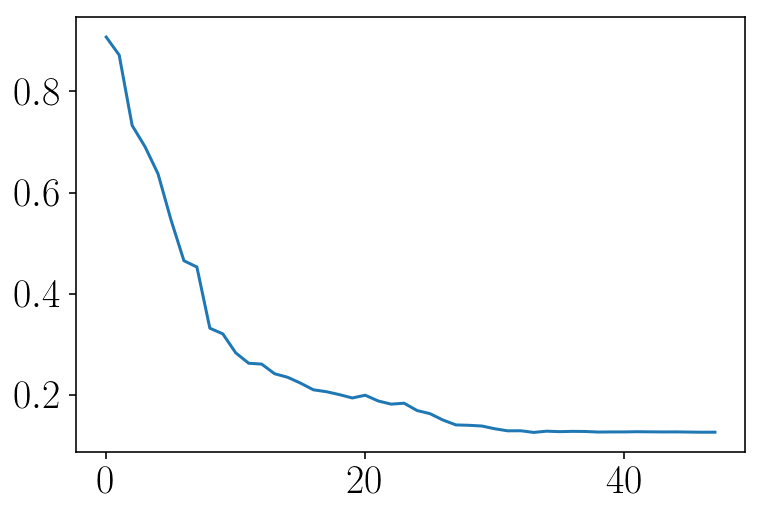

In [38]:
plt.plot(test_err)

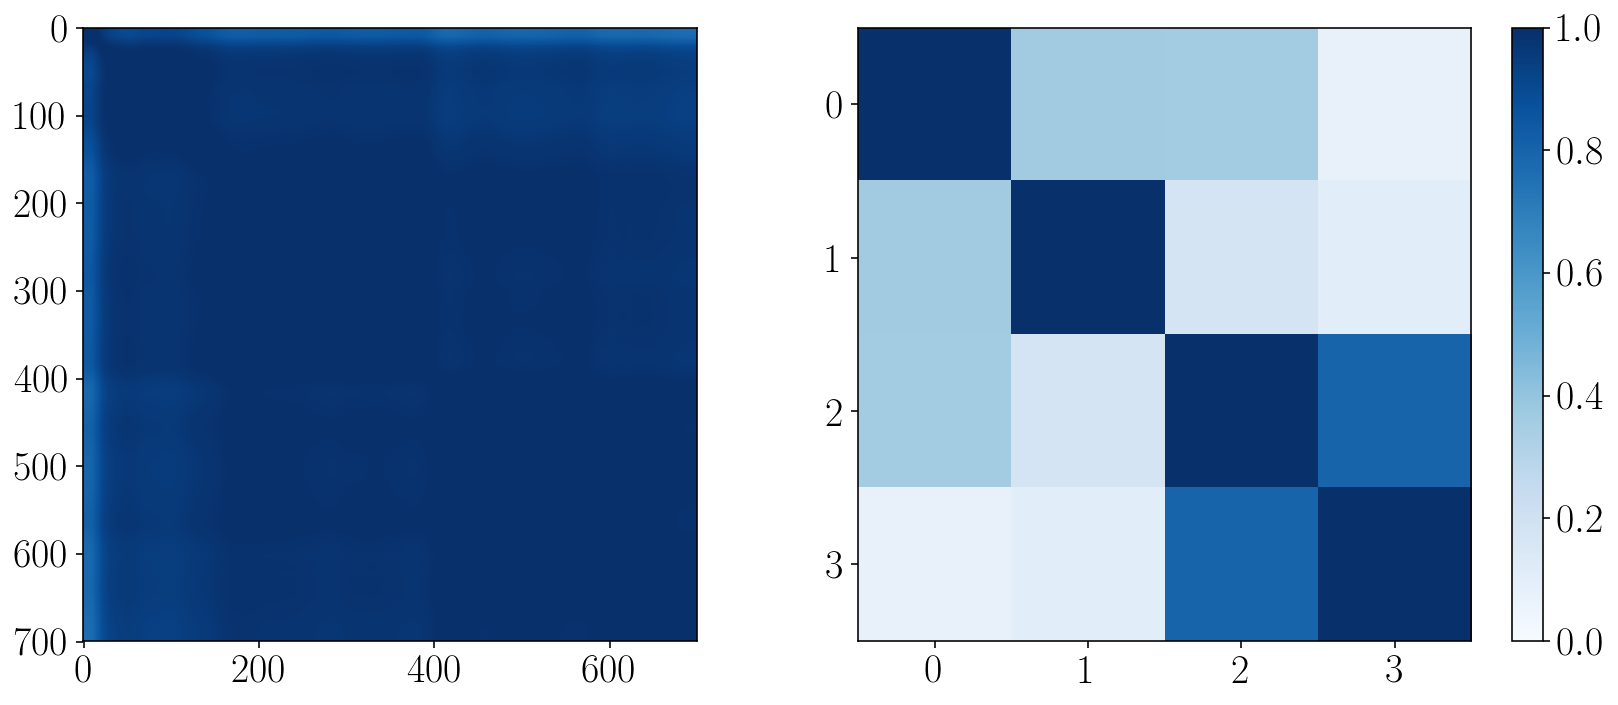

In [39]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(get_corr_matrix(Xtrain)), vmin=0., vmax=1., cmap='Blues')
#plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.abs(get_corr_matrix(Ytrain)), vmin=0., vmax=1., cmap='Blues')
plt.colorbar()
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('figs2/corr_matrix.eps', format='eps')
plt.show()

In [22]:
lr.fit(Xtrain[:, :100], Ytrain)

print(metric_nmse(Xtrain[:, :100], Ytrain, lr))
print(metric_nmse(Xtest[:, :100], Ytest, lr))

4.77102331084e-13
0.66440093631


In [45]:
qpfs = QPFS()

qpfs.fit(Xtrain, Ytrain)

In [46]:
qpfs = QPFS()

qpfs.fit(Xtrain, Ytrain)

In [ ]:
plot_score(qpfs.zx, 'figs/feature_scores_ex.eps')

In [8]:
def get_metrics(n_active_array, modes, score_history, Xtrain, Ytrain, Xtest, Ytest):
    results = {}
    results['score'] = []
    results['train_rmse'] =[]
    results['test_rmse'] = []
    results['stability'] = []
    results['vif'] = []
    results['aic'] = []
    results['bic'] = []
    results['corr'] = []
    results['modes'] = modes
    results['n_active_array'] = n_active_array.tolist()
    
    Q = get_corr_matrix(Xtrain)
    B = get_corr_matrix(Xtrain, Ytrain)
    
    for score in tqdm_notebook(score_history, leave=False):
        idxs_sort = score.argsort()[::-1]

        train_rmse = []
        test_rmse = []
        train_rmse_pls = []
        test_rmse_pls = []
        stability = []
        vif = []
        bic = []
        aic = []
        corr = []

        for k in tqdm_notebook(n_active_array, leave=False):
            active_idxs = idxs_sort[:k]
            lr.fit(Xtrain[:, active_idxs], Ytrain)
            train_rmse.append(metric_nmse(Xtrain[:, active_idxs], Ytrain, lr))
            test_rmse.append(metric_nmse(Xtest[:, active_idxs], Ytest, lr))
            stability.append(metric_stability(Xtrain[:, active_idxs]))
            vif.append(metric_vif(active_idxs))
            bic.append(metric_bic(Xtrain[:, active_idxs], Ytrain, lr))
            aic.append(metric_aic(Xtrain[:, active_idxs], Ytrain, lr))
            corr.append(np.mean(np.diag(metric_corr(Q, B, active_idxs))))

        results['score'].append(score[idxs_sort].tolist())
        results['train_rmse'].append(train_rmse)
        results['test_rmse'].append(test_rmse)
        results['stability'].append(stability)
        results['vif'].append(vif)
        results['bic'].append(bic)
        results['aic'].append(aic)
        results['corr'].append(corr)
        
    return results


def get_bootstrap(X, Y):
    n = X.shape[0]
    idxs = np.random.choice(np.arange(n), size=n)
    return X[idxs], Y[idxs]

In [9]:
def plot_metrics(results):
    n_feats = []
    fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
    for i, score in enumerate(results['score'][0]):
        n_feats.append(np.sum(score > 1e-3))
        if i in [2, 4]: continue
        p = ax[0, 0].semilogy(score[:n_features // 2], label=results['modes'][i], linewidth=2.0)
        ax[0, 0].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[0, 0].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)

    ax[0, 0].set_ylabel('Importance')

#     for i, (r, s) in enumerate(zip(*results['train_rmse'])):
#         if i in [2]: continue
#         p = ax[1, 0].plot(results['n_active_array'], r, label=results['modes'][i], linewidth=2.0)
#         ax[1, 0].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
#         ax[1, 0].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)
#     ax[1, 0].set_ylabel('sRMSE train')

    for i, (r, s) in enumerate(zip(*results['test_rmse'])):
        if i in [2, 4]: continue
        p = ax[1, 0].plot(results['n_active_array'], r, label=results['modes'][i], linewidth=2.0)
        ax[1, 0].fill_between(results['n_active_array'], r - s, r + s, alpha=0.3)
        ax[1, 0].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[1, 0].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)

    ax[1, 0].set_ylabel('sRMSE test')
    ax[1, 0].set_xlabel('Features')

#     for i, (r, s) in enumerate(zip(*results['stability'])):
#         if i in [2]: continue
#         p = ax[0, 1].plot(results['n_active_array'], r, label=results['modes'][i], linewidth=2.0)
#         ax[0, 1].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
#         ax[0, 1].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)
#     ax[0, 1].set_ylabel('Stability')
#     ax[0, 1].legend()
    
    for i, (r, s) in enumerate(zip(*results['corr'])):
        if i in [2, 4]: continue
        p = ax[0, 1].plot(results['n_active_array'], r, label=results['modes'][i], linewidth=2.0)
        ax[0, 1].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[0, 1].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)

    ax[0, 1].set_ylabel('Multicorrelation')
    ax[0, 1].legend()
    
    for i, (r, s) in enumerate(zip(*results['bic'])):
        if i in [2, 4]: continue
        p = ax[1, 1].plot(results['n_active_array'], r, label=results['modes'][i], linewidth=2.0)
        ax[1, 1].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[1, 1].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)

    ax[1, 1].set_ylabel('BIC')
    ax[1, 1].set_xlabel('Features')

    fig.tight_layout()
    plt.savefig('figs/nir_metrics.pdf', format='pdf')
    plt.show()

In [55]:
qpfs = QPFS()
mqpfs = MultivariateQPFS()

In [ ]:
n_restarts = 5
modes = ['RelAgg', 'SymImp', 'MaxMin', 'MinMax', 'MaxRel', 'AsymImp']

qpfs.fit(Xtrain, Ytrain)

score_history = [qpfs.zx]

mqpfs.get_params(Xtrain, Ytrain)
for mode in modes[1:]:
    print(mode)
    alphas = mqpfs.get_alpha(mode)
    mqpfs.solve_problem(alphas, mode)
    score_history.append(mqpfs.zx)

n_active_array = np.arange(1, n_features // 2, 10)

for i in range(n_restarts):
    print(i)
    X, Y = get_bootstrap(Xtrain, Ytrain)
    results = get_metrics(n_active_array, modes, score_history, 
                          X, Y, Xtest, Ytest)

    with open('res/qpfs_vs_mqpfs_nir_bootstrap_{}.json'.format(i), 'w') as f:
        f.write(json.dumps(results))

In [11]:
n_restarts = 5

agg_results = {'score': [],
               'train_rmse': [], 
               'test_rmse': [], 
               'stability': [],
               'vif': [],
               'aic': [],
               'bic': [],
               'corr': []
              }

for i in range(n_restarts):
    with open('res/qpfs_vs_mqpfs_nir_bootstrap_{}.json'.format(i), 'r') as f:
        results = json.loads(f.read())
    for key in agg_results:
        agg_results[key].append(results[key])

for key in agg_results:
    ar = np.array(agg_results[key])
    agg_results[key] = (ar.mean(axis=0), ar.std(axis=0))

agg_results['modes'] = results['modes']
agg_results['n_active_array'] = results['n_active_array']

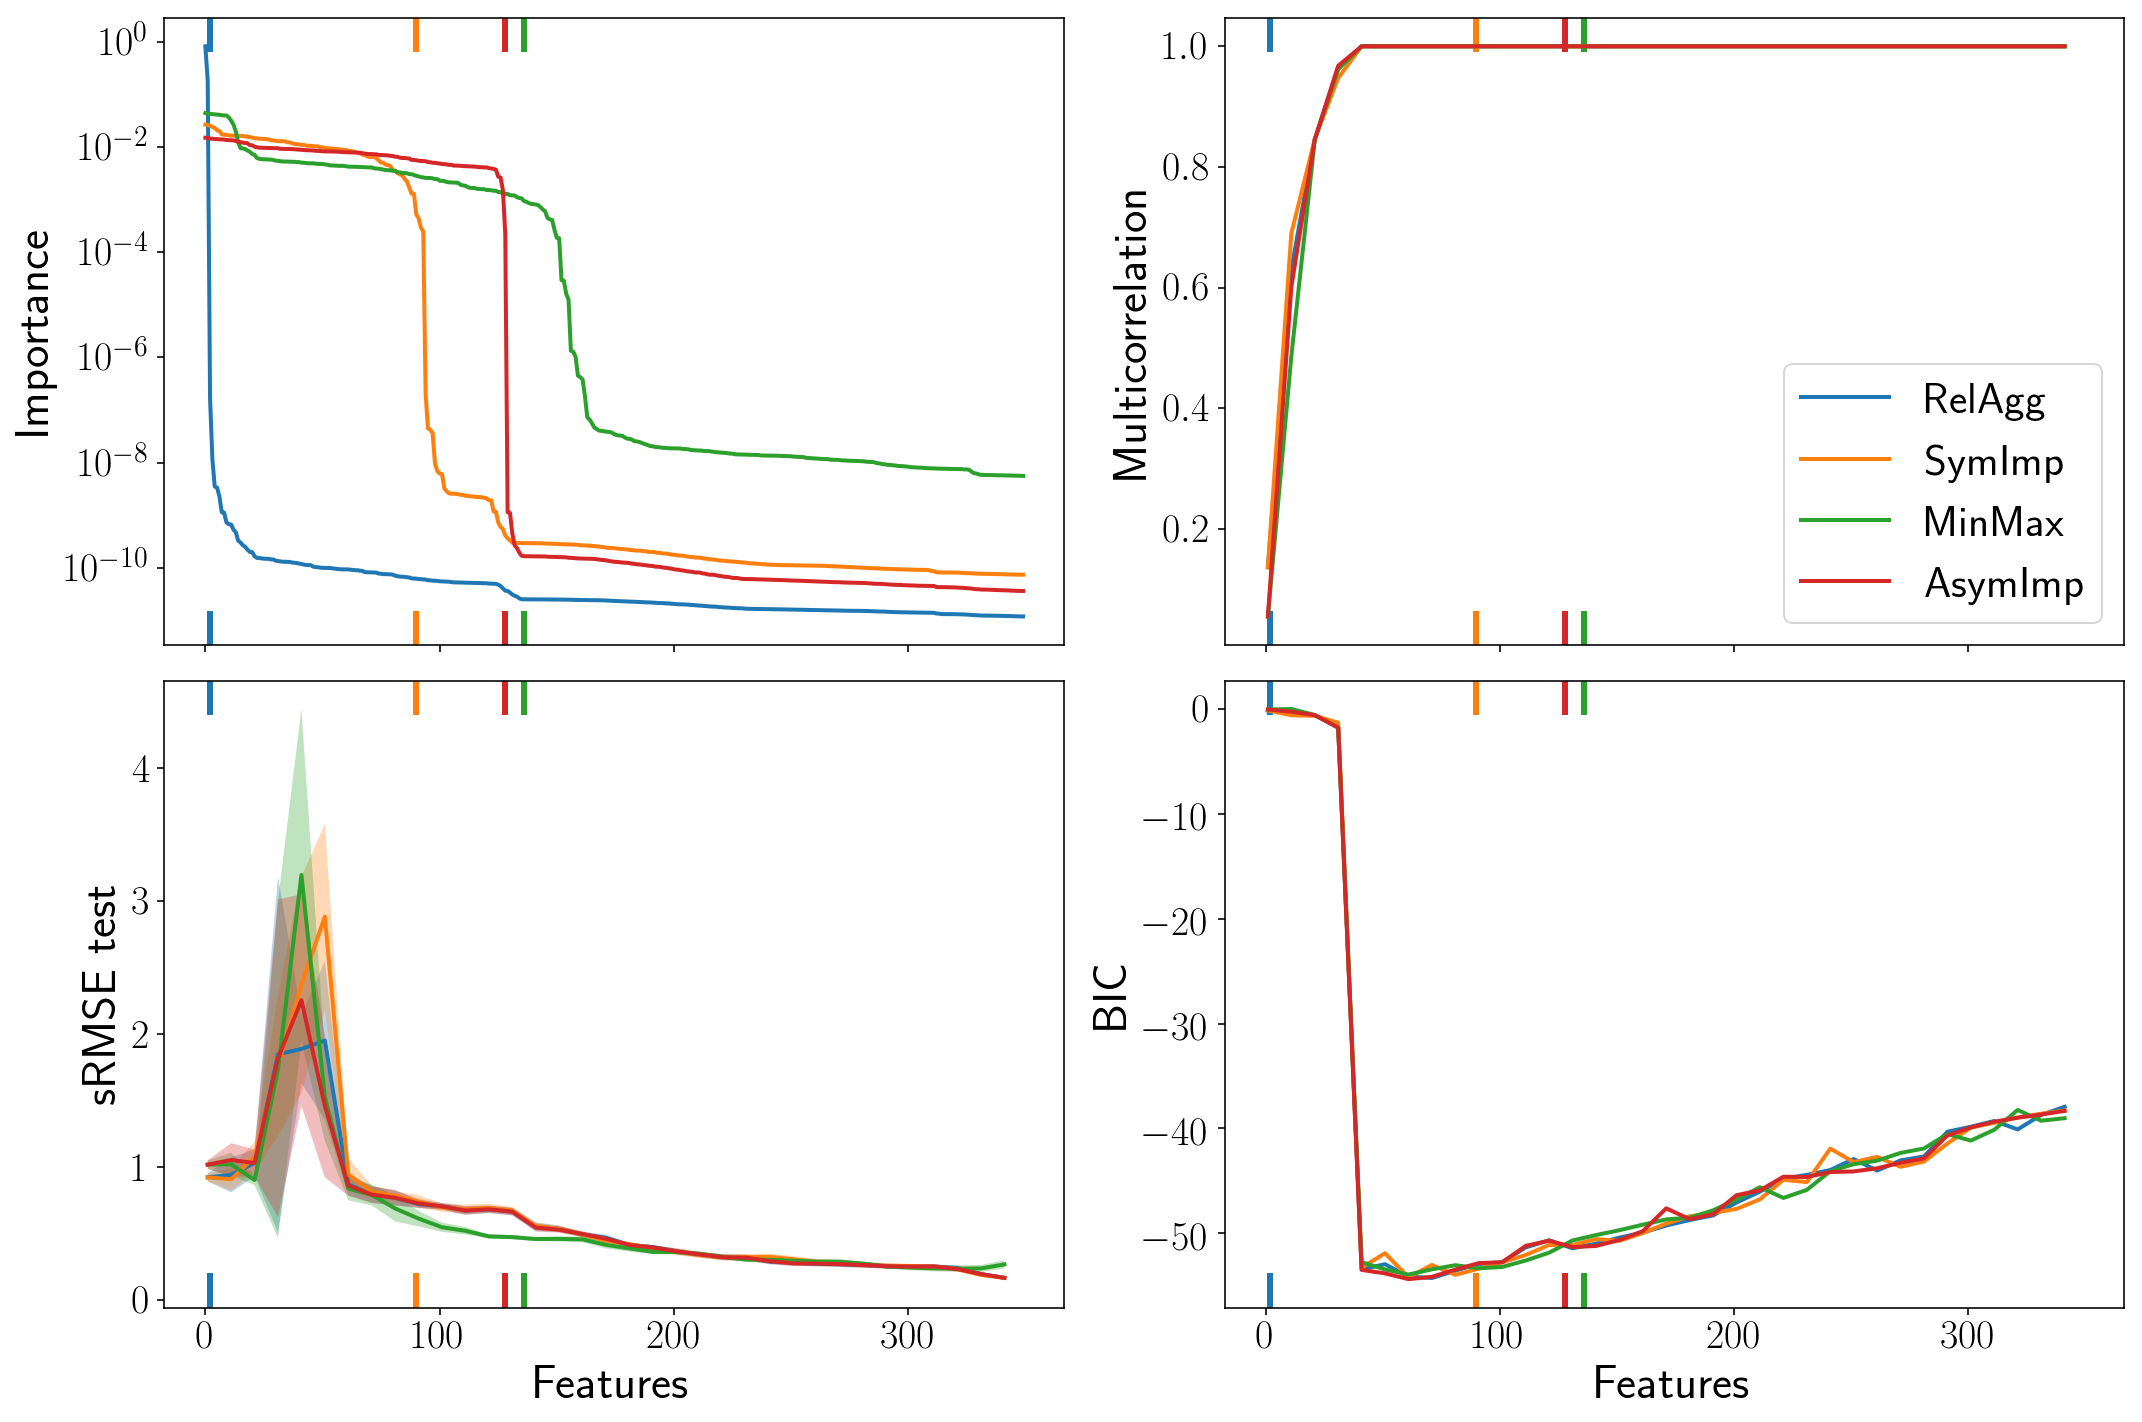

In [14]:
plot_metrics(agg_results)